17225924/17225924 [==============================] - 13s 1us/step
Epoch 1/10
58/58 [==============================] - 27s 444ms/step - loss: 1.2351 - accuracy: 0.5076 - val_loss: 0.6444 - val_accuracy: 0.7031
Epoch 2/10
58/58 [==============================] - 26s 450ms/step - loss: 0.6960 - accuracy: 0.6866 - val_loss: 0.5158 - val_accuracy: 0.7798
Epoch 3/10
58/58 [==============================] - 26s 453ms/step - loss: 0.5433 - accuracy: 0.7661 - val_loss: 0.3995 - val_accuracy: 0.8613
Epoch 4/10
58/58 [==============================] - 26s 455ms/step - loss: 0.4509 - accuracy: 0.8128 - val_loss: 0.3544 - val_accuracy: 0.8777
Epoch 5/10
58/58 [==============================] - 26s 459ms/step - loss: 0.3909 - accuracy: 0.8547 - val_loss: 0.2986 - val_accuracy: 0.9119
Epoch 6/10
58/58 [==============================] - 26s 455ms/step - loss: 0.3639 - accuracy: 0.8569 - val_loss: 0.2734 - val_accuracy: 0.9152
Epoch 7/10
58/58 [==============================] - 27s 464ms/step - loss: 0

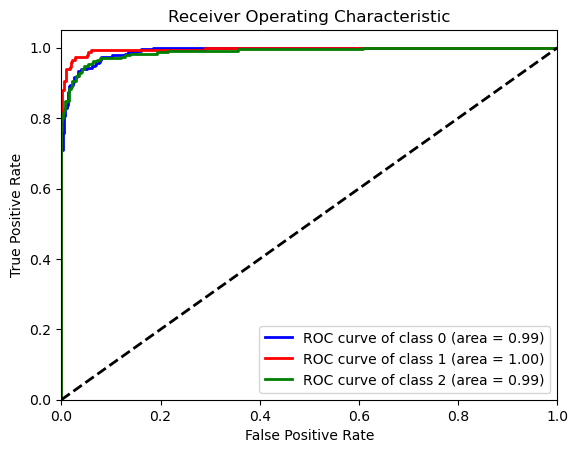

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle

data_dir = 'C:/Users/AI/tester01'

image_paths = []
labels = []

# Loop through each label in the dataset directory
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    # Loop through each image file in label directory
    for image_file in os.listdir(label_path):
        image_paths.append(os.path.join(label_path, image_file))
        labels.append(label)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

images = [np.array(Image.open(img_path).resize((224, 224))) for img_path in image_paths]
X = np.array(images, dtype=np.float32) / 255.0
y = np.array(labels_encoded)

X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Using pretrained MobileNet
mobilenet_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg')

mobilenet_model.trainable = False

model = Sequential([
    mobilenet_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

# Fit the ImageDataGenerator on training data
train_datagen.fit(X_train_temp)


model.fit(train_datagen.flow(X_train_temp, y_train_temp, batch_size=32), 
          epochs=10,
          validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


# Predict probabilities for each class
y_pred = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [2]:
model.save('cataract_model_zyhl.h5')